# iOS device sensors

- *Accelerometer* - indicates the instantaneous acceleration of the device in three dimensional space

- *Gyroscope* - indicatates the instantaneous rotation around the device's three primary axes

- *Magnetometer* - indicates the device's orientation relative to Earth's magnetic field

## Data sample example

In [1]:
!head -5 data/sensors_data_2.txt

0,1559326636.829958,0.255325,-0.502029,-1.028046,0.443951,0.200743,0.415666,29.606125,-74.604645,18.656082
0,1559326636.839992,0.240738,-0.478897,-0.918045,0.325636,0.133373,0.397889,29.620789,-75.026749,18.934021
0,1559326636.850026,0.228043,-0.491455,-0.774460,0.213884,0.053723,0.346770,29.286835,-74.661758,18.959671
0,1559326636.860060,0.225693,-0.490204,-0.683121,0.115481,-0.005978,0.297200,29.212784,-75.049469,18.875061
0,1559326636.870094,0.215073,-0.467896,-0.619659,0.004867,-0.054696,0.251627,29.286987,-75.029800,19.014252


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd

# 50Hz
freq = 50
data_dir = 'data'

columns = ['mode', 'timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z']

datasets_trunc = []
data_files = !ls {data_dir}
for file_name in data_files:
    file_path = os.path.join(data_dir, file_name)
    data = pd.read_csv(file_path, sep=',', header=None, names=columns)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    data.set_index('timestamp', inplace=True)
    data = data[30*freq: -30*freq] # trip 30 sec, both ends
    datasets_trunc.append(data)
    print('loaded: %s \tlen: %d' % (file_path, len(data)))

loaded: data/sensors_data_10.txt 	len: 33667
loaded: data/sensors_data_11.txt 	len: 34751
loaded: data/sensors_data_12.txt 	len: 28587
loaded: data/sensors_data_14.txt 	len: 29161
loaded: data/sensors_data_15.txt 	len: 120406
loaded: data/sensors_data_16.txt 	len: 46404
loaded: data/sensors_data_17.txt 	len: 36692
loaded: data/sensors_data_18.txt 	len: 404
loaded: data/sensors_data_2.txt 	len: 9181
loaded: data/sensors_data_20.txt 	len: 42670
loaded: data/sensors_data_3.txt 	len: 7316
loaded: data/sensors_data_4.txt 	len: 2972
loaded: data/sensors_data_5.txt 	len: 27768
loaded: data/sensors_data_6.txt 	len: 16155
loaded: data/sensors_data_7.txt 	len: 26962
loaded: data/sensors_data_8.txt 	len: 27688
loaded: data/sensors_data_9.txt 	len: 36273


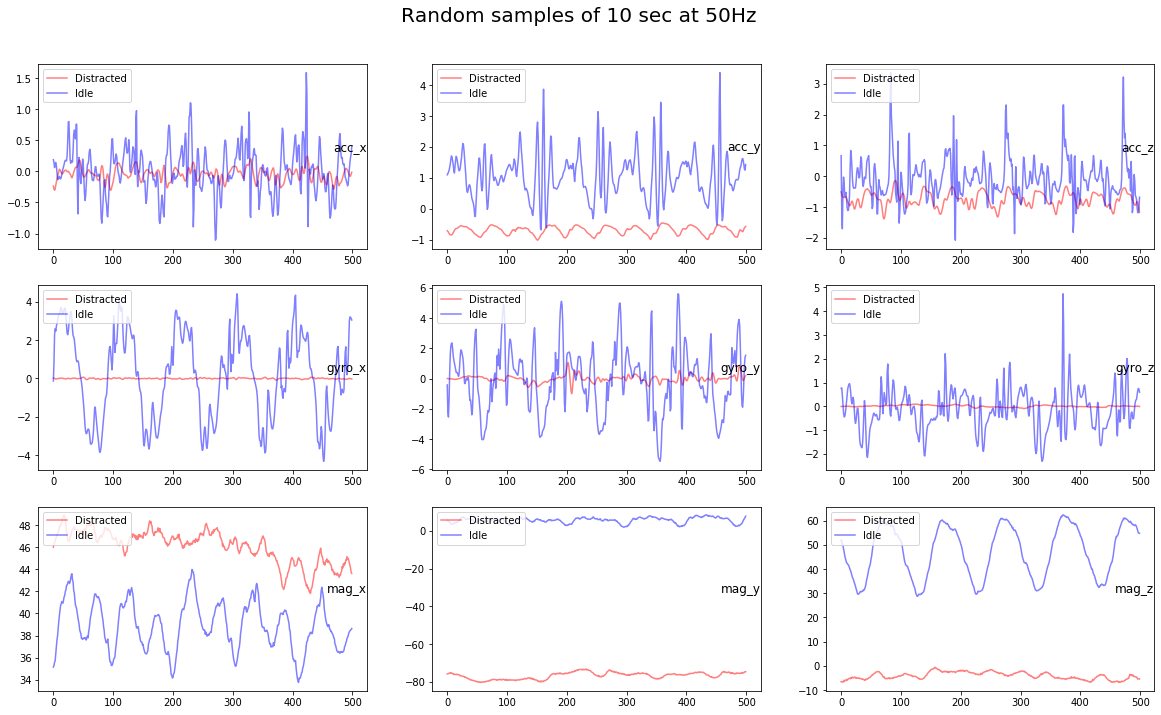

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

secs = 10 # plot 10 sec only

def plot_data(dfs):
    fdf = dfs[0]
    nrows = len(fdf.columns)
    cols = fdf.columns

    i = 1
    fig = plt.figure(figsize=(20, 40))
    title = "Random samples of %i sec at %iHz" % (secs, freq)
    fig.suptitle(title, fontsize=20, y=0.9)
    for row in range(1, nrows):
        plt.subplot(nrows, 3, i)
        for j in range(len(dfs)):
            values = dfs[j]
            begin = random.randint(0, len(values) - secs * freq)
            end = begin + secs * freq
            values = values.iloc[begin:end, :] 
            values = values.reset_index(drop=True)

            is_dist = values.iloc[0][0]
            label = "Distracted" if is_dist == 1 else "Idle"
            color = "red" if is_dist == 1 else "blue"
            
            plt.plot(values.iloc[:, row], alpha=0.5, label=label, color=color)
            plt.legend(loc=2)
        plt.title(cols[row], y=0.5, loc='right')
        i += 1
    plt.show()

for i in range(0, 1):
    plot_data([datasets_trunc[0], datasets_trunc[1]])

In [5]:
def unroll_df(df, wind_size=128):
    mode = df.iloc[0]['mode'].astype(int)
    data = df.drop('mode', axis=1)
    unrld_data = []
    proc_len = 0
    while (proc_len + wind_size) < len(data):
        data_batch = data[proc_len:proc_len+wind_size]
        data_batch.reset_index(drop=True)
        values = data_batch.unstack(level=1).values
        unrld_data.append(values)
        proc_len += wind_size

    proc_data = pd.DataFrame(unrld_data)
    proc_data['label'] = mode
    proc_data.head()
    return proc_data

In [6]:
unrolled_datasets = []
for dataset in datasets_trunc:
    unrolled_datasets.append(unroll_df(dataset, wind_size=50))
    
dataset = pd.concat(unrolled_datasets, axis=0)

In [7]:
dataset.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,label
35,-1.357925,-1.360504,-1.348709,-1.337234,-1.326981,-1.311584,-1.304688,-1.277786,-1.251541,-1.212433,...,24.743484,21.674927,24.527954,21.576920,23.839127,21.117630,24.030853,21.081299,23.882797,0
808,0.375992,0.180939,0.051788,0.004822,0.043976,0.065216,0.033127,0.008606,-0.022324,-0.132645,...,29.061020,27.844696,27.237854,26.529510,26.402695,26.134415,26.254761,25.750626,25.885345,0
350,-0.451202,-0.382523,-0.535477,-0.683945,-0.732834,-0.473740,-0.062683,0.189926,0.254593,0.261276,...,60.216431,59.589661,58.693893,58.186371,57.405075,56.906601,56.588379,55.678207,55.060379,0
577,0.121521,0.154358,0.161652,0.155319,0.125763,0.073593,0.011703,-0.045181,-0.084595,-0.107101,...,-3.785324,-3.564896,-3.538376,-3.383438,-3.054520,-2.995010,-2.757584,-2.650604,-2.302582,1
322,-1.479721,-1.475052,-1.433426,-1.373779,-1.311737,-1.266647,-1.224762,-1.191238,-1.159760,-1.134857,...,19.198059,19.619400,18.961441,19.720932,19.349258,19.684372,19.803375,20.241043,19.840561,0


## Preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from utils import *

In [9]:
X = dataset.drop('label', axis=1).values
Y = dataset['label'].values

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)

## Model

In [11]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Activation, Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [12]:
def MyModel_LSTM():
    in_data = Input(shape=(50*9, ), dtype='float32')
    X = Reshape((50,9,), input_shape=(50*9,))(in_data)
    X = LSTM(50, return_sequences=True)(X)
    X = Dropout(0.5)(X)
    X = LSTM(50)(X)
    X = Dropout(0.5)(X)
    X = Dense(100, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=in_data, outputs=X)
    return model

# LSTM isnt supported on Android :(
def MyModel_FC():
    in_data = Input(shape=(50*9, ), dtype='float32')
    X = Dense(50, activation='relu')(in_data)
    X = Dropout(0.5)(X)
    X = Dense(50, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(20, activation='relu')(X)    
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=in_data, outputs=X)
    return model

In [ ]:
del model

In [13]:
model = MyModel_LSTM()
# model = MyModel_FC()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 9)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
mc = ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [16]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=100, \
                    callbacks=[es, mc], validation_split=0.1)

Train on 8532 samples, validate on 949 samples
Epoch 1/100
8532/8532 [==============================] - 7s 870us/step - loss: 0.1376 - accuracy: 0.9478 - val_loss: 0.0221 - val_accuracy: 0.9916

Epoch 00001: val_accuracy improved from -inf to 0.99157, saving model to model.h5
Epoch 2/100
8532/8532 [==============================] - 6s 719us/step - loss: 0.0250 - accuracy: 0.9921 - val_loss: 0.0084 - val_accuracy: 0.9979

Epoch 00002: val_accuracy improved from 0.99157 to 0.99789, saving model to model.h5
Epoch 3/100
8532/8532 [==============================] - 6s 701us/step - loss: 0.0193 - accuracy: 0.9950 - val_loss: 0.0079 - val_accuracy: 0.9989

Epoch 00003: val_accuracy improved from 0.99789 to 0.99895, saving model to model.h5
Epoch 4/100
8532/8532 [==============================] - 6s 698us/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0310 - val_accuracy: 0.9926

Epoch 00004: val_accuracy did not improve from 0.99895
Epoch 5/100
8532/8532 [==============================]

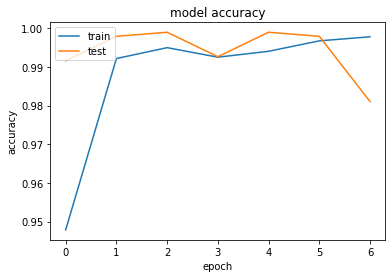

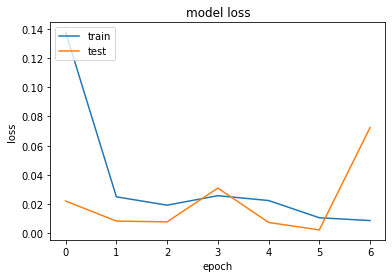

In [17]:
plot_model_accuracy(history)
plot_model_loss(history)

In [18]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test loss = ", loss)
print("Test accuracy = ", acc)

1054/1054 [==============================] - 0s 220us/step
Test loss =  0.05048587065997694
Test accuracy =  0.9838709831237793


In [ ]:
del model

model = load_model('model.h5')
model.summary()

In [ ]:
# brew install GraphViz
from keras.utils import plot_model
plot_model(model)

## TensorFlow Lite model

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model_file('model.h5')
tflite_model = converter.convert()
open('model.tflite', 'wb').write(tflite_model)